This example illustrates an analysis of a RADICAL-Pilot run on OSG with 8 CUs
and 4 pilots. The profile and json file for the run can be found in
examples/data/rp.session.radical.mingtha.017035.0010.

In [55]:
import os
import sys
import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

Acquire the execution data for each entity of the run and construct a ra.session object. We define a function to do it as we will want to create multiple sessions for multiple runs.

In [133]:
def load_data(loc):
    sid   = os.path.basename(glob.glob('%s/*.json' % loc)[0])[:-5]
    descr = rp.utils.get_session_description(sid=sid, src=loc)
    prof  = rp.utils.get_session_profile(sid=sid, src=loc)

    return ra.Session(prof, descr)

We construct a sesion for each run we have and we store all the sessions in a dictionary (ignore the WARNINGS).

In [134]:
runs = ['rp.session.radical.mingtha.017033.0007', 
        'rp.session.radical.mingtha.017034.0003', 
        'rp.session.radical.mingtha.017035.0003', 
        'rp.session.radical.mingtha.017035.0010', 
        'rp.session.radical.mingtha.017033.0008', 
        'rp.session.radical.mingtha.017034.0004', 
        'rp.session.radical.mingtha.017035.0005', 
        'rp.session.radical.mingtha.017035.0011',
        'rp.session.radical.mingtha.017033.0009', 
        'rp.session.radical.mingtha.017034.0005', 
        'rp.session.radical.mingtha.017035.0006', 
        'rp.session.radical.mingtha.017035.0012',
        'rp.session.radical.mingtha.017034.0002', 
        'rp.session.radical.mingtha.017034.0006', 
        'rp.session.radical.mingtha.017035.0008', 
        'rp.session.radical.mingtha.017035.0015']

sessions = {}

for run in runs:
    sessions[run] = load_data('../data/'+run)

We define a set of durations we want to measure and their semantics. Each
duration has two and only two timestamps, the first always preceding in
time the second. Each timestamp represents an event, in this case to a
state transition.

Our choice of the durations depends on the design of the experiment for
which we are collecting data. In this case, we want to measure the
overall time to completion (TTC) of the run and isolate two of its
components: the amoung of time spent in the queue waiting for the pilots
to become available and the amount of time spent to execute each unit.

We need to define the start and end event for these three durations and,
as such, we need to choose the entity or entities that are relevant to
our measurment. The first step is therefore to look at what entities were
recorded in the data of the run, and at what was their state model.

As seen in example 02, we look at the list of entities recorded in the
run:

In [138]:
for sid in sessions.keys():
    print "%s: %s" % (sid, sessions[sid].list(['etype']))

rp.session.radical.mingtha.017035.0008: [['umgr', 'pmgr', 'update', 'session', 'unit', 'pilot']]
rp.session.radical.mingtha.017035.0005: [['umgr', 'pmgr', 'update', 'session', 'unit', 'pilot']]
rp.session.radical.mingtha.017035.0011: [['umgr', 'pmgr', 'update', 'session', 'unit', 'pilot']]
rp.session.radical.mingtha.017035.0010: [['umgr', 'pmgr', 'update', 'session', 'unit', 'pilot']]
rp.session.radical.mingtha.017034.0002: [['umgr', 'pmgr', 'update', 'session', 'unit', 'pilot']]
rp.session.radical.mingtha.017035.0015: [['umgr', 'pmgr', 'update', 'session', 'unit', 'pilot']]
rp.session.radical.mingtha.017035.0003: [['umgr', 'pmgr', 'update', 'session', 'unit', 'pilot']]
rp.session.radical.mingtha.017033.0007: [['umgr', 'pmgr', 'update', 'session', 'unit', 'pilot']]
rp.session.radical.mingtha.017035.0012: [['umgr', 'pmgr', 'update', 'session', 'unit', 'pilot']]
rp.session.radical.mingtha.017034.0006: [['umgr', 'pmgr', 'update', 'session', 'unit', 'pilot']]
rp.session.radical.mingtha.017

And we choose 'session', 'pilot', and 'unit'. We do not care 'umgr',
'pmgr', 'update' as we care only about the overall duration of the run
(for which we use the satates of session) and measuring aggregates
durations for pilots and units, not for the RP managers.

We look at the states of the entity 'session' (TO BE IMPLEMENTED):

In [139]:
for sid in sessions.keys():
    print "%s: %s" % (sid, sessions[sid].describe('state_model', etype=['session']))

rp.session.radical.mingtha.017035.0008: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017035.0005: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017035.0011: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017035.0010: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017034.0002: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017035.0015: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017035.0003: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017033.0007: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017035.0012: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017034.0006: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017034.0005: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017034.0004: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017034.0003: {'session': {'state_model': {}}}
rp.session.radical.mingtha.017035.0006: {'session':

We look at the states of the entity 'pilot' for one of the session we have. We know all the sessions are the same so we can avoid to inspect all of them:

In [142]:
sessions.itervalues().next().describe('state_values', etype=['pilot'])

{'pilot': {'state_values': {-1: None,
   0: 'NEW',
   1: 'LAUNCHING_PENDING',
   2: 'LAUNCHING',
   3: 'ACTIVE_PENDING',
   4: 'ACTIVE',
   5: ['FAILED', 'DONE', 'CANCELED']}}}

From the RADICAL-Pilot documentation and state model description, we know that a pilot is described, it is assigned to a pmgr, and scheduled on its target resource queue. We use 'LAUNCHING_PENDING' as the event indicating that a pilot has been queued, and LAUNCHING' and the indication that a pilot has been scheduled on the compute nodes by the resource's batch system (e.g., PBS). We indicate queue time with Tq and measure it for each pilot as:

Tq = LAUNCHING - LAUNCHING_PENDING

We should note that in presence of multiple pilots, the queue time of one or more pilot can overlap, partially overlap, or not overlap. When calculating the total amount of queue time for the whole run, we need to account fo overlappings and therefore for time subtractions or addition. Luckily, the method session.duration does all this for us.

As seen in example 04:

In [143]:
pilots = {}
Tqs = {}

for sid in sessions.keys():
    pilots[sid] = sessions[sid].filter(etype='pilot', inplace=False)
    #Tq = pilots.duration([rp.LAUNCHING_PENDING, rp.LAUNCHING])
    Tqs[sid] = pilots[sid].duration(['LAUNCHING_PENDING', 'LAUNCHING'])
    print "%s: Tq = %s" % (sid, Tqs[sid])

rp.session.radical.mingtha.017035.0008: Tq = 0.00200009346008
rp.session.radical.mingtha.017035.0005: Tq = 0.0019998550415
rp.session.radical.mingtha.017035.0011: Tq = 0.00209999084473
rp.session.radical.mingtha.017035.0010: Tq = 0.00180006027222
rp.session.radical.mingtha.017034.0002: Tq = 0.00209999084473
rp.session.radical.mingtha.017035.0015: Tq = 0.00239992141724
rp.session.radical.mingtha.017035.0003: Tq = 0.00220012664795
rp.session.radical.mingtha.017033.0007: Tq = 0.00209999084473
rp.session.radical.mingtha.017035.0012: Tq = 0.00200009346008
rp.session.radical.mingtha.017034.0006: Tq = 0.00209999084473
rp.session.radical.mingtha.017034.0005: Tq = 0.00209999084473
rp.session.radical.mingtha.017034.0004: Tq = 0.0019998550415
rp.session.radical.mingtha.017034.0003: Tq = 0.00219988822937
rp.session.radical.mingtha.017035.0006: Tq = 0.00220012664795
rp.session.radical.mingtha.017033.0008: Tq = 0.00190019607544
rp.session.radical.mingtha.017033.0009: Tq = 0.00219988822937


We measure also Tq for each pilot indipendently. Depending on their overlapping, the overall Tq might be the a value between the sum of 4 indipendent Tq or the value of the longest Tq.

We print also their state models so to check how they performed after leaving the queue. This will give an insight for when we will look at the portion of TTC spent executing units. For example, did units execute on a single pilot or were they distributed across multiple pilots?

In [146]:
for sid in sessions.keys():
    print "\n%s:" % sid
    for p in pilots[sid].list('uid'):
        pilot = sessions[sid].filter(uid=p, inplace=False)
        print "\t%s\n\tStates: %s" % (p, pilot.list('state'))
        print "\tTq: %s" % pilot.duration(['LAUNCHING_PENDING', 'LAUNCHING'])


rp.session.radical.mingtha.017035.0008:
	pilot.0002
	States: ['ACTIVE_PENDING', 'LAUNCHING_PENDING', 'DONE', 'ACTIVE', 'NEW', 'LAUNCHING']
	Tq: 0.00200009346008
	pilot.0003
	States: ['ACTIVE_PENDING', 'LAUNCHING_PENDING', 'CANCELED', 'DONE', 'ACTIVE', 'NEW', 'LAUNCHING']
	Tq: 0.00200009346008
	pilot.0000
	States: ['ACTIVE_PENDING', 'LAUNCHING_PENDING', 'CANCELED', 'DONE', 'ACTIVE', 'NEW', 'LAUNCHING']
	Tq: 0.00200009346008
	pilot.0001
	States: ['ACTIVE_PENDING', 'LAUNCHING_PENDING', 'CANCELED', 'DONE', 'ACTIVE', 'NEW', 'LAUNCHING']
	Tq: 0.00200009346008

rp.session.radical.mingtha.017035.0005:
	pilot.0002
	States: ['ACTIVE_PENDING', 'LAUNCHING_PENDING', 'CANCELED', 'ACTIVE', 'NEW', 'LAUNCHING']
	Tq: 0.0019998550415
	pilot.0003
	States: ['ACTIVE_PENDING', 'LAUNCHING_PENDING', 'CANCELED', 'ACTIVE', 'NEW', 'LAUNCHING']
	Tq: 0.0019998550415
	pilot.0000
	States: ['ACTIVE_PENDING', 'LAUNCHING_PENDING', 'CANCELED', 'ACTIVE', 'NEW', 'LAUNCHING']
	Tq: 0.0019998550415
	pilot.0001
	States: ['ACT

We now look at the states of the entity 'unit':

In [147]:
sessions.itervalues().next().describe('state_values', etype=['unit'])

{'unit': {'state_values': {-1: None,
   0: 'NEW',
   1: 'UMGR_SCHEDULING_PENDING',
   2: 'UMGR_SCHEDULING',
   3: 'UMGR_STAGING_INPUT_PENDING',
   4: 'UMGR_STAGING_INPUT',
   5: 'AGENT_STAGING_INPUT_PENDING',
   6: 'AGENT_STAGING_INPUT',
   7: 'AGENT_SCHEDULING_PENDING',
   8: 'AGENT_SCHEDULING',
   9: 'AGENT_EXECUTING_PENDING',
   10: 'AGENT_EXECUTING',
   11: 'AGENT_STAGING_OUTPUT_PENDING',
   12: 'AGENT_STAGING_OUTPUT',
   13: 'UMGR_STAGING_OUTPUT_PENDING',
   14: 'UMGR_STAGING_OUTPUT',
   15: ['FAILED', 'CANCELED', 'DONE']}}}

From the RADICAL-Pilot documentation and state model description, we know that a unit is executing its kernel between AGENT_EXECUTING and AGENT_STAGING_OUTPUT_PENDING. We define execution time as:

Tx = AGENT_STAGING_OUTPUT_PENDING - AGENT_EXECUTING

As done with the pilot, we first calculate the overall time spent during the session to execute CUs.

In [148]:
units = {}
Txs = {}

for sid in sessions.keys():
    units[sid] = sessions[sid].filter(etype='unit', inplace=False)
    #Tq = pilots.duration([rp.LAUNCHING_PENDING, rp.LAUNCHING])
    Txs[sid] = units[sid].duration(['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])

    print "%s: Tx = %s" % (sid, Txs[sid])

rp.session.radical.mingtha.017035.0008: Tx = 7250.37669992
rp.session.radical.mingtha.017035.0005: Tx = 5443.03279996
rp.session.radical.mingtha.017035.0011: Tx = 894.549900055
rp.session.radical.mingtha.017035.0010: Tx = 784.315799952
rp.session.radical.mingtha.017034.0002: Tx = 5909.71959996
rp.session.radical.mingtha.017035.0015: Tx = 897.362699986
rp.session.radical.mingtha.017035.0003: Tx = 1396.23060012
rp.session.radical.mingtha.017033.0007: Tx = 1293.90070009
rp.session.radical.mingtha.017035.0012: Tx = 800.716799974
rp.session.radical.mingtha.017034.0006: Tx = 3171.11420012
rp.session.radical.mingtha.017034.0005: Tx = 1884.11720014
rp.session.radical.mingtha.017034.0004: Tx = 2978.92389989
rp.session.radical.mingtha.017034.0003: Tx = 1581.1967001
rp.session.radical.mingtha.017035.0006: Tx = 1569.82069993
rp.session.radical.mingtha.017033.0008: Tx = 4681.26889992
rp.session.radical.mingtha.017033.0009: Tx = 2574.20889997


We measure also Tx for each unit indipendently.

In [149]:
Tuxs = []

for sid in sessions.keys():
    for u in units[sid].list('uid'):
        unit = sessions[sid].filter(uid=u, inplace=False)
        Tux = unit.duration(['AGENT_EXECUTING', 'AGENT_STAGING_OUTPUT_PENDING'])
        Tuxs.append(Tux)
        print "%s; Tx: %s" % (u, Tux)

unit.000018; Tx: 502.729199886
unit.000019; Tx: 439.666800022
unit.000030; Tx: 440.256599903
unit.000031; Tx: 431.325599909
unit.000036; Tx: 404.039599895
unit.000037; Tx: 446.670899868
unit.000034; Tx: 461.782500029
unit.000053; Tx: 480.127000093
unit.000010; Tx: 501.004400015
unit.000011; Tx: 419.207899809
unit.000012; Tx: 483.382799864
unit.000013; Tx: 475.154500008
unit.000014; Tx: 418.62319994
unit.000015; Tx: 412.107599974
unit.000016; Tx: 433.4599998
unit.000017; Tx: 476.719399929
unit.000057; Tx: 406.235199928
unit.000029; Tx: 453.41050005
unit.000028; Tx: 452.75
unit.000002; Tx: 414.362100124
unit.000052; Tx: 434.615599871
unit.000032; Tx: 494.593800068
unit.000035; Tx: 476.88560009
unit.000003; Tx: 442.32889986
unit.000024; Tx: 475.768699884
unit.000061; Tx: 405.493000031
unit.000060; Tx: 542.686199903
unit.000063; Tx: 498.724300146
unit.000062; Tx: 484.026800156
unit.000023; Tx: 418.042099953
unit.000001; Tx: 396.265000105
unit.000047; Tx: 456.945799828
unit.000046; Tx: 429.

This shows that Tx is relatively uniform. We calculate and plot $\sigma$

μ = 337.003765085
σ = 98.0969553779
D = 28.5546146702


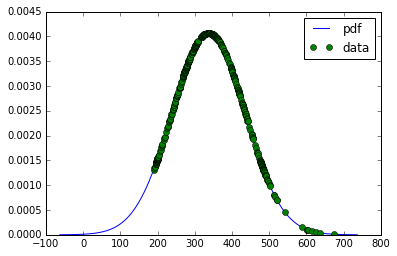

In [152]:
Tuxs = sorted(Tuxs)

u_mu = np.mean(Tuxs)
u_sigma = np.std(Tuxs)

print u'\u03BC'+" = %s" % u_mu
print u'\u03C3'+" = %s" % u_sigma
print "D = %s" % ((u_sigma)**2/u_mu)

x = np.linspace(u_mu-400, u_mu+400, len(Tuxs))
plt.plot(x, mlab.normpdf(x, u_mu, u_sigma), label="pdf")
plt.plot(Tuxs, mlab.normpdf(Tuxs, u_mu, u_sigma), 'o', label="data")
plt.legend(loc='best')

plt.show()